In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import random
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time


In [2]:
#載入圖片特徵
#於image_feature.ipynb中實作並儲存
train_features = np.load('feature/train_features_lenet.npy', allow_pickle=True)
train_labels = np.load('feature/train_labels.npy', allow_pickle=True)
val_features = np.load('feature/val_features_lenet.npy', allow_pickle=True)
val_labels = np.load('feature/val_labels.npy', allow_pickle=True)
test_features = np.load('feature/test_features_lenet.npy', allow_pickle=True)
test_labels = np.load('feature/test_labels.npy', allow_pickle=True)

In [3]:
def one_hot_encoding(y):
    y=y.astype(int) #將label的0~49轉成數字
    num_classes = 50 #共50個label
    y_onehot = np.zeros((len(y), num_classes))
    y_onehot[np.arange(len(y)), y] = 1.0 #轉成one hot
    return y_onehot

def union_shuffle(X, y):
    X=X.astype(float) #features的原始讀取到的資料型態是object，轉成float
    index = np.arange(X.shape[0])
    np.random.shuffle(index) #將資料排序打亂
    return X[index], y[index]


In [4]:
# One-hot encode labels
y_train = one_hot_encoding(train_labels)
y_valid = one_hot_encoding(val_labels)
y_test = one_hot_encoding(test_labels)

# Shuffle data
x_train, y_train = union_shuffle(train_features, y_train)
x_val, y_val = union_shuffle(val_features, y_valid)
x_test, y_test = union_shuffle(test_features, y_test)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(y_train[1])

(63325, 32, 32, 1)
(63325, 50)
(450, 32, 32, 1)
(450, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


### Lenet5 

In [6]:
# transpose
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_val = np.transpose(x_val, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

In [7]:
print(x_train[0])
print(x_train.shape)

[[[0.11372549 0.13333334 0.14901961 ... 0.07058824 0.07058824 0.32156864]
  [0.15294118 0.14509805 0.10588235 ... 0.06666667 0.07058824 0.32549021]
  [0.19215687 0.07450981 0.06666667 ... 0.07450981 0.09803922 0.33333334]
  ...
  [0.13725491 0.0627451  0.03137255 ... 0.23921569 0.21176471 0.23529412]
  [0.20392157 0.08627451 0.03921569 ... 0.19215687 0.1882353  0.1882353 ]
  [0.18039216 0.15294118 0.05490196 ... 0.17254902 0.17254902 0.33333334]]]
(63325, 1, 32, 32)


In [8]:
# # 將特徵轉換為 PyTorch 張量
x_train_tensor = torch.from_numpy(x_train).float()
x_val_tensor = torch.from_numpy(x_val).float()

y_train_tensor = torch.FloatTensor(y_train)  # Convert target variable to Long data type
y_val_tensor = torch.FloatTensor(y_val)      # Convert target variable to Long data type


In [9]:
# 創建 PyTorch 的 DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
print(x_train_tensor.shape)

torch.Size([63325, 1, 32, 32])


### chatGPT

In [11]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self, num_classes=50):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 16 * 5 * 5)
        x = self.classifier(x)
        return x


In [12]:
learning_rate = 0.001
num_epochs = 10


In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


In [14]:
%%time

# Define the LeNet-5 model, loss function and optimizer# Create an instance of the LeNet-5 model
model = LeNet5().to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 定義存儲 loss 和 accuracy 的列表
# 儲存每個epoch的損失和準確率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

CPU times: user 3.17 s, sys: 1.59 s, total: 4.76 s
Wall time: 7.55 s


In [15]:
%%time

for epoch in range(num_epochs):
    # 訓練模式
    model.train()
    train_loss = 0.0
    correct_train = 0

    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 步驟 1: 正向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 步驟 2: 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 累計訓練損失
        train_loss += loss.item() * images.size(0)
        
        # 計算訓練集準確率        
        predicted_train = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        correct_train += (predicted_train == labels).sum().item()
    
    # 計算訓練集的平均損失
    train_loss /= len(train_dataset)
    train_accuracy = correct_train / len(train_dataset)

    
    # 評估模式
    model.eval()
    val_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # 正向傳播
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            # 計算準確率
            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
    
    # 計算測試集的平均損失和準確率
    val_loss /= len(val_dataset)
    val_accuracy = correct / len(val_dataset)
    
    # 將 loss 和 accuracy 儲存起來
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # 列印每個epoch的訓練和測試結果
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print()
    # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
Train Loss: 3.6129 | Train Accuracy: 0.0714
Validation Loss: 3.4230 | Validation Accuracy: 0.0889

Epoch 2/10
Train Loss: 3.3739 | Train Accuracy: 0.1118
Validation Loss: 3.3144 | Validation Accuracy: 0.1244

Epoch 3/10
Train Loss: 3.2894 | Train Accuracy: 0.1306
Validation Loss: 3.2480 | Validation Accuracy: 0.1178

Epoch 4/10
Train Loss: 3.2353 | Train Accuracy: 0.1417
Validation Loss: 3.2031 | Validation Accuracy: 0.1533

Epoch 5/10
Train Loss: 3.1877 | Train Accuracy: 0.1513
Validation Loss: 3.1696 | Validation Accuracy: 0.1467

Epoch 6/10
Train Loss: 3.1550 | Train Accuracy: 0.1609
Validation Loss: 3.1743 | Validation Accuracy: 0.1667

Epoch 7/10
Train Loss: 3.1267 | Train Accuracy: 0.1674
Validation Loss: 3.2160 | Validation Accuracy: 0.1822

Epoch 8/10
Train Loss: 3.1042 | Train Accuracy: 0.1726
Validation Loss: 3.1611 | Validation Accuracy: 0.1644

Epoch 9/10
Train Loss: 3.0795 | Train Accuracy: 0.1772
Validation Loss: 3.2193 | Validation Accuracy: 0.1644

Epoch 10/1

### Predicted Result

- Validation set

In [16]:
# 测试模式
model.eval()
predict_val_loss = 0.0
predict_val_correct_test = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 正向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        predict_val_loss += loss.item() * images.size(0)
        
        # 计算测试集准确率
        predicted_test = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        predict_val_correct_test += (predicted_test == labels).sum().item()

# 计算测试集的平均损失和准确率
predict_val_loss /= len(val_dataset)
predict_val_accuracy = predict_val_correct_test / len(val_dataset)

print(f"Predicted validation Loss: {predict_val_loss:.4f} | Predicted validation Accuracy: {predict_val_accuracy:.4f}")

Predicted validation Loss: 3.1441 | Predicted validation Accuracy: 0.1644


- Testing set

In [17]:
x_test_tensor = torch.from_numpy(x_test).float()
# # y_val_tensor = torch.from_numpy(y_val).long()

y_test_tensor = torch.FloatTensor(y_test) 

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# 测试模式
model.eval()
test_loss = 0.0
correct_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 正向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        # 计算测试集准确率
        predicted_test = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        # _, predicted_test = torch.max(outputs, 1)
        correct_test += (predicted_test == labels).sum().item()

# 计算测试集的平均损失和准确率
test_loss /= len(test_dataset)
test_accuracy = correct_test / len(test_dataset)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Test Loss: 3.0858 | Test Accuracy: 0.1933


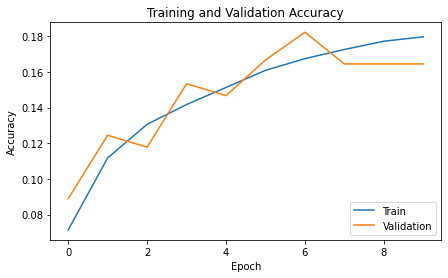

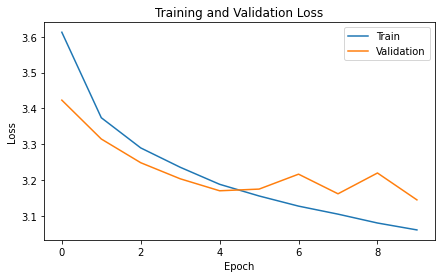

In [18]:
import matplotlib.pyplot as plt


# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('pytorch_acc.png')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('pytorch_loss.png')
plt.show()

### Inference time

In [19]:
# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Generate random input tensor
input_shape = (batch_size, 1, 32, 32)  # Define the input shape
input_tensor = torch.randn(input_shape).to(device)

# Warm-up the model
_ = model(input_tensor)

# Measure inference time
total_time = 0
num_iterations = 100  # Number of iterations for measurement
for _ in range(num_iterations):
    torch.cuda.synchronize()  # Synchronize CUDA operations
    start_time = time.time()

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)

    torch.cuda.synchronize()  # Synchronize CUDA operations
    end_time = time.time()

    iteration_time = end_time - start_time
    total_time += iteration_time

average_time = total_time / num_iterations
print("Average Inference Time: %.6f seconds" % average_time)


Average Inference Time: 0.000497 seconds


In [20]:
# Generate random input tensor for one batch
input_shape = (batch_size, 1, 32, 32)  # Define the input shape
input_tensor = torch.randn(input_shape).to(device)

# Warm-up the model
_ = model(input_tensor)

# Measure inference time
torch.cuda.synchronize()  # Synchronize CUDA operations
start_time = time.time()

# Forward pass
with torch.no_grad():
    output = model(input_tensor)

torch.cuda.synchronize()  # Synchronize CUDA operations
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time: %.6f seconds" % inference_time)

Inference Time: 0.000774 seconds


### FLOPs、Space complexity

In [21]:
from thop import profile

# 创建一个示例输入张量
input_shape = (batch_size, 1, 32, 32)  # (batch_size, channels, height, width)

input_tensor = torch.randn(input_shape).to(device)
input_list = [input_tensor]

# 使用torchprofile估计FLOPs和参数数量
flops, params = profile(model, input_list)

print("LeNet-5 FLOPs: %.4f MFLOPs" % (flops / 1e6))
print("LeNet-5 Parameters: %.4f Million" % (params / 1e6))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
LeNet-5 FLOPs: 13.4362 MFLOPs
LeNet-5 Parameters: 0.0651 Million
